In [1]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
import os
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.metrics
import sklearn.datasets
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
sns.set_style(style='white')

In [3]:
methylation_beta = pd.read_csv("../Carter Lab Datasets/DNA Methylation Data/pancan_methylation_coordinates_mean_beta.csv")
methylation_beta.head()

,Unnamed: 0,CpG ID,CHR,MAPINFO,mean_beta
0,0,cg00005617,X,68059898.0,0.676049
1,1,cg00006815,X,103810908.0,0.203507
2,2,cg00008932,X,71498597.0,0.718252
3,3,cg00008945,X,80377379.0,0.161582
4,4,cg00011200,X,48380234.0,0.221467


In [10]:
methylation_beta.shape

(396000, 5)

In [5]:
promoter_regions = pd.read_csv("../Carter Lab Datasets/Promoter Data/promoter_regions.txt", sep='\t', comment='t', header=None)
header = ["chr", "start", "end", "col3", "col4", "strand"]
promoter_regions.columns = header[:len(promoter_regions.columns)]
del promoter_regions["col3"]
del promoter_regions["col4"]
promoter_regions = promoter_regions.drop_duplicates()
promoter_regions

,chr,start,end,strand
0,chr1,10873.0,11873.0,+
3,chr1,16765.0,17765.0,-
4,chr1,17751.0,18751.0,-
5,chr1,18061.0,19061.0,-
6,chr1,19759.0,20759.0,NaN
...,...,...,...,...
82950,chr19_gl000209_random,85690.0,86690.0,+
82951,chr19_gl000209_random,97111.0,98111.0,+
82952,chr19_gl000209_random,114098.0,115098.0,+
82955,chr19_gl000209_random,130448.0,131448.0,+


In [9]:
common_TADs = pd.read_csv("../Carter Lab Datasets/common_TADs_meQTLs.csv")
common_TADs

,Unnamed: 0,chr1,x1,x2,chr2,y1,y2,color,f1,f2,...,H3K27me3,H4K20me1,#meqtl,KMeans_State_Labels,#meqtl_pos,#meqtl_neg,domain_size,norm_meqtl_by_size,norm_pos_meqtl_by_size,norm_neg_meqtl_by_size
0,0,1,36960000,37910000,1,36960000,37910000,"255,255,0",1.8249,0.079690,...,0.167622,0.705304,206,4,71,141,950000,0.062006,0.021654,0.047834
1,1,1,38485000,39310000,1,38485000,39310000,"255,255,0",1.7513,0.051417,...,0.226065,0.369001,219,4,122,97,825000,0.075906,0.042846,0.037893
2,2,1,157140000,157480000,1,157140000,157480000,"255,255,0",1.3679,0.065425,...,0.275085,0.000000,283,4,90,194,340000,0.238009,0.076695,0.183891
3,3,1,64075000,64730000,1,64075000,64730000,"255,255,0",1.3300,0.074093,...,0.244738,0.000000,301,4,201,189,655000,0.131405,0.088911,0.092995
4,4,1,110325000,110530000,1,110325000,110530000,"255,255,0",1.5128,0.032783,...,0.499037,0.704529,38,0,26,22,205000,0.053005,0.036747,0.034587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1095,X,117750000,117955000,X,117750000,117955000,"255,255,0",1.2678,0.032125,...,0.000000,0.000000,0,0,0,0,205000,0.000000,0.000000,0.000000
1096,1096,X,37785000,38035000,X,37785000,38035000,"255,255,0",1.5301,0.051187,...,1.000000,0.000000,0,1,0,0,250000,0.000000,0.000000,0.000000
1097,1097,X,109150000,109385000,X,109150000,109385000,"255,255,0",1.0945,0.040047,...,0.000000,1.000000,0,1,0,0,235000,0.000000,0.000000,0.000000
1098,1098,X,102790000,102945000,X,102790000,102945000,"255,255,0",1.2129,0.041055,...,0.000000,0.000000,0,1,0,0,155000,0.000000,0.000000,0.000000


In [10]:
overlap_TAD_promoter = pd.DataFrame()
overlap_chr = []
overlap_start = []
overlap_end = []
overlap_labels = []
overlap_num = []
overlap_ind = []
for i, row in common_TADs.iterrows():
    if i%100 == 0:
        print(i)
    tad_start = row["x1"]
    tad_end = row["x2"]
    start_pos_1 = promoter_regions["start"]
    end_pos_1 = promoter_regions["end"]
    common_chr = promoter_regions[promoter_regions["chr"] == "chr"+row["chr1"]]
    cond1 = common_chr[(start_pos_1 >= tad_start) & (end_pos_1 <= tad_end)]
    overlap_chr += list(cond1["chr"])
    overlap_start += list((cond1["start"]))
    overlap_end += list((cond1["end"]))
    overlap_labels += [int(row["KMeans_State_Labels"])]*(int(len(cond1)))
    overlap_num.append(len(cond1))
    overlap_ind += [i]*(len(cond1))
overlap_TAD_promoter["chr"] = overlap_chr
overlap_TAD_promoter["start"] = overlap_start
overlap_TAD_promoter["end"] = overlap_end
overlap_TAD_promoter["label"] = overlap_labels
overlap_TAD_promoter["TAD Index"] = overlap_ind
overlap_TAD_promoter


0
100
200
300
400
500
600
700
800
900
1000


,chr,start,end,label,TAD Index
0,chr1,37499844.0,37500844.0,4,0
1,chr1,37626163.0,37627163.0,4,0
2,chr1,38512450.0,38513450.0,4,1
3,chr1,38553902.0,38554902.0,4,1
4,chr1,38680439.0,38681439.0,4,1
...,...,...,...,...,...
6561,chrX,24167771.0,24168771.0,0,1099
6562,chrX,24166761.0,24167761.0,0,1099
6563,chrX,24168807.0,24169807.0,0,1099
6564,chrX,24189831.0,24190831.0,0,1099


In [39]:
len(overlap_num)

1100

In [11]:
overlap_TAD_promoter = overlap_TAD_promoter.drop_duplicates()
overlap_TAD_promoter

,chr,start,end,label,TAD Index
0,chr1,37499844.0,37500844.0,4,0
1,chr1,37626163.0,37627163.0,4,0
2,chr1,38512450.0,38513450.0,4,1
3,chr1,38553902.0,38554902.0,4,1
4,chr1,38680439.0,38681439.0,4,1
...,...,...,...,...,...
6561,chrX,24167771.0,24168771.0,0,1099
6562,chrX,24166761.0,24167761.0,0,1099
6563,chrX,24168807.0,24169807.0,0,1099
6564,chrX,24189831.0,24190831.0,0,1099


In [12]:
beta_labels_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}
for i, row in overlap_TAD_promoter.iterrows():
    if i % 1000 == 0:
        print(i)
    common_chr1 = methylation_beta["chr"+methylation_beta["CHR"] == row["chr"]]
    overlap = common_chr1[(common_chr1["MAPINFO"] >= row["start"]) & (common_chr1["MAPINFO"] <= row["end"])]
    beta_labels_dict[row["label"]].append(np.mean(overlap["mean_beta"]))
                                          
beta_labels_dict

0
1000
2000
3000
4000
5000
6000


{0: [0.3387077330086757,
  0.033518191399631636,
  0.6332913733850924,
  nan,
  0.7170095996097667,
  nan,
  nan,
  0.8014332736961886,
  0.023585936598403724,
  nan,
  0.041178483645018006,
  0.04328370962507913,
  0.035070560938759106,
  0.05421182820050138,
  0.04912239447720035,
  0.9286073358881408,
  0.7367626347007707,
  0.05631175470733264,
  0.382637690007511,
  0.6341627377276507,
  0.6341627377276507,
  nan,
  nan,
  0.7273485718389736,
  0.05120203085410474,
  0.07058288164198429,
  0.19277234936647158,
  0.23422116875417576,
  nan,
  nan,
  nan,
  0.1366850319213972,
  nan,
  0.5875107820138706,
  nan,
  0.0692205760956676,
  0.05359864759380198,
  0.02780794361242259,
  nan,
  0.47991773138796967,
  0.06679102632907381,
  nan,
  nan,
  nan,
  0.026389594564513563,
  0.913691529248999,
  0.048601864740563924,
  0.05374340763180322,
  0.06214385362107749,
  0.06214385362107749,
  0.16977315886771147,
  0.6705076829470189,
  nan,
  nan,
  0.369880450414903,
  0.0758901978844

In [13]:
for i in range(5):
    beta_labels_dict[i]=[x for x in beta_labels_dict[i] if ~np.isnan(x)]


In [21]:
stats.kruskal(beta_labels_dict[0], beta_labels_dict[1], beta_labels_dict[2], beta_labels_dict[3], beta_labels_dict[4])

KruskalResult(statistic=233.54588264615066, pvalue=2.2761530935915483e-49)

In [ ]:
print(np.median(beta_labels_dict[0]), np.median())

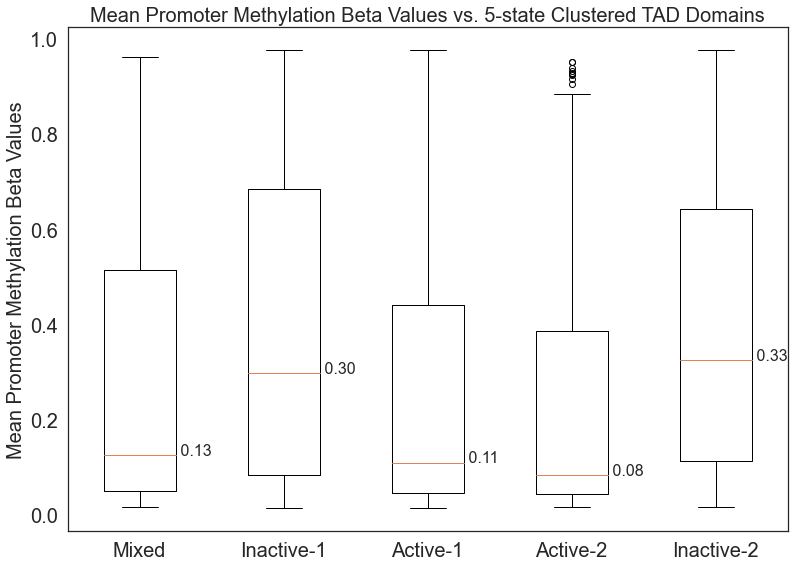

In [24]:
data = [beta_labels_dict[0], beta_labels_dict[1], beta_labels_dict[2], beta_labels_dict[3], beta_labels_dict[4]]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
boxplt = ax.boxplot(data)
for i, line in enumerate(boxplt['medians']):
    x, y = line.get_xydata()[1]
    #text = ' median={:.2f}'.format(np.median(data[i]))
    text = ' {:.2f}'.format(np.median(data[i]))
    ax.annotate(text, xy=(x, y), fontsize=16)
plt.ylabel("Mean Promoter Methylation Beta Values", fontsize=20)
plt.title("Mean Promoter Methylation Beta Values vs. 5-state Clustered TAD Domains", fontsize=20)
ax.set_xticklabels(['Mixed', 'Inactive-1','Active-1', 'Active-2', 'Inactive-2'], fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [10]:
cancer_meqtls = pd.read_csv("Carter Lab Datasets/meQTL Data/all_cancers_meQTLs.csv")
cancer_meqtls

,Unnamed: 0,cancer_type,snp,snp_position,alleles,probes,probe_position,probe_gene,beta,status,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,chr,bp
0,0,BLCA,rs11684598,chr2:33952621,G/A,cg04131969,chr2:33951647,MYADML,-1.24,-40.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr2,33952621
1,1,BLCA,rs12232965,chr2:33954560,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr2,33954560
2,2,BLCA,rs7574695,chr2:33953186,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr2,33953186
3,3,BLCA,rs11777332,chr8:91676709,G/A,cg16814680,chr8:91681699,NaN,-1.20,-36.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr8,91676709
4,4,BLCA,rs4332092,chr8:91677926,G/A,cg16814680,chr8:91681699,NaN,-1.20,-36.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr8,91677926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11616294,293448,UCEC,rs1601870,chr3:14024162,T/C,cg23070574,chr3:14187308,XPC,0.42,4.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr3,14024162
11616295,293449,UCEC,rs10903612,chr10:2018353,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr10,2018353
11616296,293450,UCEC,rs4880953,chr10:2019373,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr10,2019373
11616297,293451,UCEC,rs11002432,chr10:79931884,C/T,cg15849445,chr10:80635973,NaN,0.58,4.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr10,79931884


In [47]:
meqtl_labels_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}
for i, row in overlap_TAD_promoter.iterrows():
    if i % 1000 == 0:
        print(i)
    common_chr1 = cancer_meqtls[cancer_meqtls["chr"] == row["chr"]]
    overlap = common_chr1[(common_chr1["bp"] >= row["start"]) & (common_chr1["bp"] <= row["end"])]
    if (overlap_num[row["TAD Index"]]) != 0:
        meqtl_labels_dict[row["label"]].append(len(overlap["snp"])/(overlap_num[row["TAD Index"]]))
    else:
        meqtl_labels_dict[row["label"]].append(len(overlap["snp"]))
meqtl_labels_dict

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


{0: [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.05263157894736842,
  0.05263157894736842,
  0.0,
  0.15789473684210525,
  0.10526315789473684,
  0.10526315789473684,
  1.0526315789473684,
  0.3157894736842105,
  1.8421052631578947,
  1.8421052631578947,
  2.8947368421052633,
  0.0,
  0.0,
  0.0,
  0.0,
  3.111111111111111,
  3.111111111111111,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.5555555555555556,
  0.5555555555555556,
  1.2222222222222223,
  0.3333333333333333,
  0.3333333333333333,
  1.2222222222222223,
  1.2222222222222223,
  14.555555555555555,
  14.555555555555555,
  0.0,
  2.6666666666666665,
  3.0,
  0.0,
  0.5,
  0.3,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.6,
  0.0,
  0.0,
  0.0,
  0.06666666666666667,
  0.6,
  1.7333333333333334,
  1.7333333333333334,
  1.0,
  1.0,
  0.0,
  1.4666666666666666,
  0.0,
  0.0,
  0.0,
 

In [48]:
for i in range(5):
    meqtl_labels_dict[i] = np.array(meqtl_labels_dict[i])/len(meqtl_labels_dict[i])
meqtl_labels_dict

{0: array([0., 0., 0., ..., 0., 0., 0.]),
 1: array([0., 0., 0., ..., 0., 0., 0.]),
 2: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.78630116e-05, 3.78630116e-05, 3.02904093e-04]),
 3: array([6.70317221e-03, 8.49697885e-04, 8.49697885e-04, 8.49697885e-04,
        1.51057402e-03, 0.00000000e+00, 1.88821752e-04, 4.72054381e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.44108761e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.55287009e-04, 3.90231621e-03, 3.90231621e-03, 3.90231621e-03,
        2.64350453e-03, 0.00000000e+00, 2.64350453e-03, 2.13997986e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.04229607e-04, 9.06344411e-04,
        9.06344411e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,

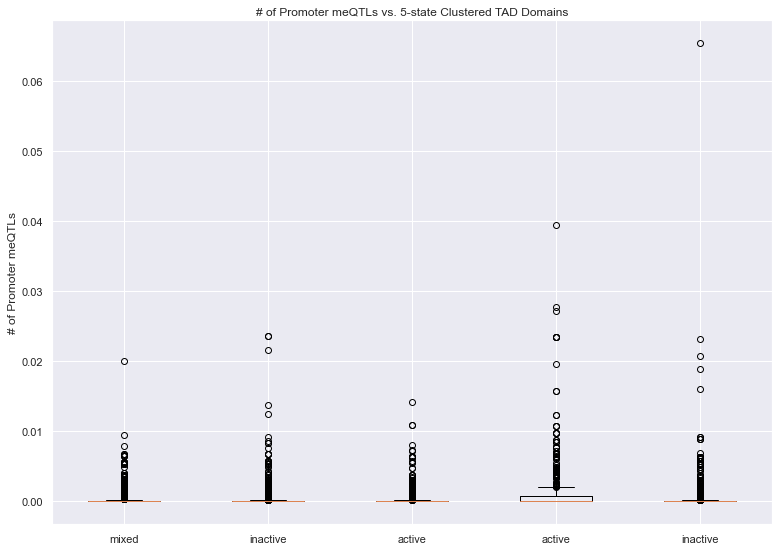

In [49]:
data2 = [meqtl_labels_dict[0], meqtl_labels_dict[1], meqtl_labels_dict[2], meqtl_labels_dict[3], meqtl_labels_dict[4]]
fig2 = plt.figure(figsize =(10, 7))
ax2 = fig2.add_axes([0, 0, 1, 1])
boxplt2 = ax2.boxplot(data2)
plt.ylabel("# of Promoter meQTLs")
plt.title("# of Promoter meQTLs vs. 5-state Clustered TAD Domains")
ax2.set_xticklabels(['mixed', 'inactive','active', 'active', 'inactive'])
plt.show()